# Distance traveled analysis


In [6]:
import os, sys
import toml
from src import settings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import fileio

CONFIG_PATH = os.path.join(settings.CONFIG_DIR, "main.toml")
with open(CONFIG_PATH, "r") as file:
    config = toml.load(file)
    
TIME_WINDOW=config["TIME_WINDOW"]

INPUT_PATH = os.path.join(settings.RESULTS_DIR, "distances_traveled")

all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key in config["TREATMENTS"]}

treatment_dataframes = []
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)
    group_dataframes = []
    for group_name, df_path in all_groups.items():
        df = pd.read_csv(df_path, index_col=0)  
        df['Snapshot'] = (df.index / config["FPS"] / TIME_WINDOW).astype(int) + 1
        df['Group'] = group_name.replace(".csv","")

        group_dataframes.append(df)

    df = pd.concat(group_dataframes)
    df.set_index('Snapshot', inplace=True)
    df.set_index('Group', append=True, inplace=True)

    df['Treatment'] = treatment_name
    df.set_index('Treatment', append=True, inplace=True)
    df = df.reorder_levels(['Treatment', 'Group', 'Snapshot'])
  
    treatment_dataframes.append(df)
    
combined_data = pd.concat(treatment_dataframes)
# sum_w = combined_data.groupby(['Snapshot', 'Treatment', 'Group']).sum().sum(axis=1).mean()

<Axes: xlabel='Treatment', ylabel='distance'>

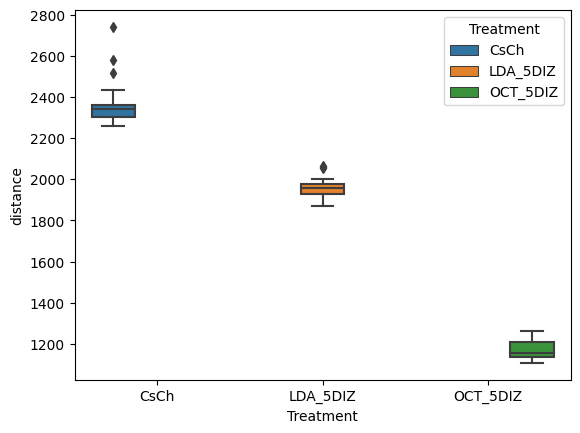

In [24]:
sum_w = pd.DataFrame()

sum_w["distance"] = combined_data.groupby(['Treatment', 'Snapshot']).sum().mean(axis=1)

sum_w = sum_w.reset_index()
sns.boxplot(data=sum_w, x='Treatment', y='distance', hue="Treatment")

In [ ]:
sum_w = pd.DataFrame()
sum_w["distance"] = combined_data.groupby(['Treatment', 'Group', 'Snapshot']).sum().sum(axis=1)

df = df.reset_index()
df.columns= ['Treatment', 'Group', 'Snapshot', "distance"]

sns.boxplot(x="Snapshot", y="distance", data=df, hue="Treatment")

In [31]:
combined_data.groupby(['Treatment', 'Group', 'Snapshot']).sum().sum(axis=1)



Treatment  Group                     Snapshot
CsCh       CsCh_A1_05_05_2023-11_21  1           4952.685697
                                     2           4548.721563
                                     3           4589.859670
                                     4           4210.858045
                                     5           4030.876880
                                                    ...     
           CsCh_A4_28_04_2023-11_20  16          5183.225950
                                     17          5024.051171
                                     18          5035.742205
                                     19          4973.735785
                                     20          5194.861643
Length: 460, dtype: float64

In [22]:
df.columns

Index(['Treatment', 'Group', 'Snapshot', 0], dtype='object')

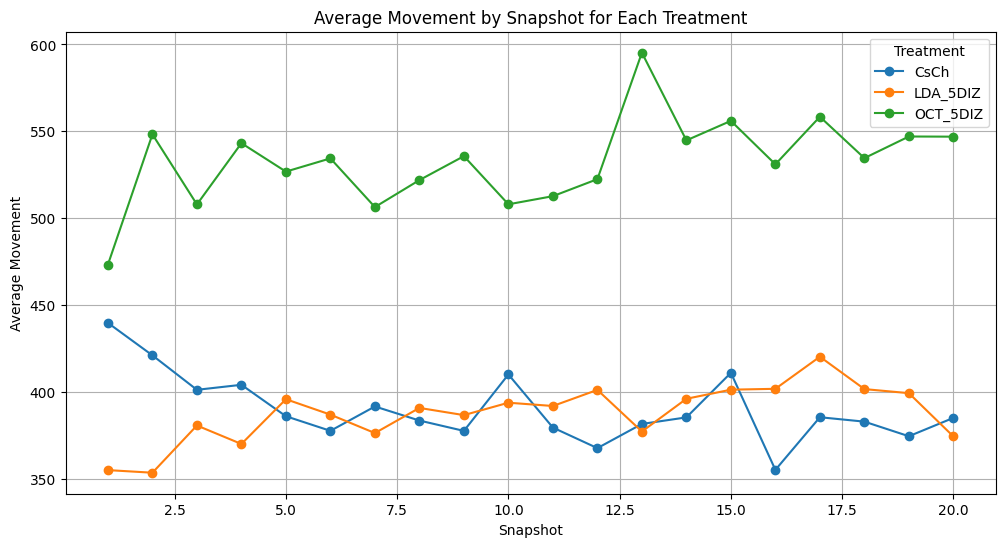

In [3]:
import matplotlib.pyplot as plt

# Assuming 'sum_w' is your Series with the average movement for each treatment and snapshot
# You can plot it as a line chart like this:
sum_w.unstack('Treatment').plot(kind='line', marker='o', figsize=(12, 6))
plt.xlabel('Snapshot')
plt.ylabel('Average Movement')
plt.title('Average Movement by Snapshot for Each Treatment')
plt.legend(title='Treatment')
plt.grid(True)
plt.show()

ValueError: 'x' and 'y' must have the same size

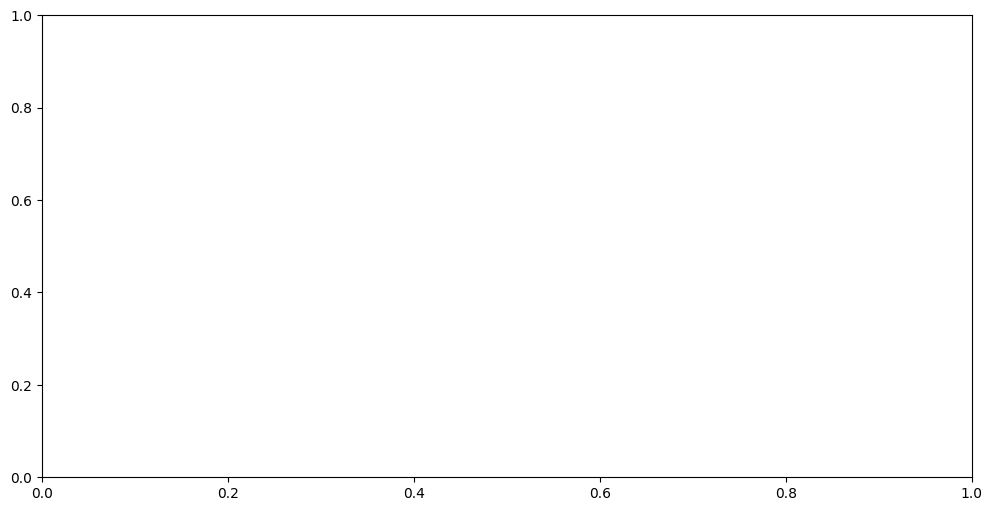

In [3]:
df = combined_data

grouped = df.groupby(['Treatment', 'Snapshot'])

means = grouped.mean()
std_devs = grouped.std()

# Extract the numeric values for the 'fly' columns
columns = ['fly9', 'fly3', 'fly2', 'fly11', 'fly12', 'fly1', 'fly6', 'fly4', 'fly7', 'fly5', 'fly8', 'fly10']

# Reshape the data for plotting
treatments = means.index.get_level_values('Treatment').unique()
snapshots = means.index.get_level_values('Snapshot').unique()
data = []

for treatment in treatments:
    treatment_data = means.xs(treatment, level='Treatment')
    error_data = std_devs.xs(treatment, level='Treatment')
    data.append((treatment_data, error_data))

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))

for treatment, error_data in data:
    x = range(len(snapshots))
    y = treatment[columns].values.ravel()
    error = error_data[columns].values.ravel()
    ax.errorbar(x, y, yerr=error, label=treatment.index[0])

ax.set_xticks(x)
ax.set_xticklabels(snapshots, rotation=45)
ax.set_xlabel('Snapshot')
ax.set_ylabel('Average Distance Traveled')
ax.set_title('Average Distance Traveled per Treatment')
ax.legend()
plt.show()